## Модель классификации токсичных комментариев

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2reckey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2reckey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\2reckey\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\2reckey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv("Data/Toxic_Comments/toxic_comments.csv")
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [6]:
df['text'] = df['text'].progress_apply(preprocess_text)

df.head()

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [01:46<00:00, 1499.35it/s]


,text,toxic
0,explanation edits made username hardcore metal...,0
1,daww match background colour im seemingly stuc...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestion improvement wondered...,0
4,sir hero chance remember page thats,0


In [7]:
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.shape

(157890, 2)

In [9]:
df_toxic = df[df["toxic"] == 1]
df_non_toxic = df[df["toxic"] == 0]

# n= 5000
# df_toxic_more = pd.concat([df_toxic.sample(n), df_non_toxic.sample(9*n)], axis=0)

df_toxic_more = pd.concat([df_toxic, df_non_toxic], axis=0)
df_toxic_more = df_toxic_more.reset_index(drop=True)
df_toxic_more

,text,toxic
0,cocksucker piss around work,1
1,hey talk exclusive group wp talibanswho good d...,1
2,bye dont look come think comming back tosser,1
3,gay antisemmitian archangel white tiger meow g...,1
4,fuck filthy mother as dry,1
...,...,...
157885,second time asking view completely contradicts...,0
157886,ashamed horrible thing put talk page,0
157887,spitzer umm there actual article prostitution ...,0
157888,look like actually put speedy first version de...,0


In [10]:
df_toxic_more[df_toxic_more["toxic"]==1]

,text,toxic
0,cocksucker piss around work,1
1,hey talk exclusive group wp talibanswho good d...,1
2,bye dont look come think comming back tosser,1
3,gay antisemmitian archangel white tiger meow g...,1
4,fuck filthy mother as dry,1
...,...,...
16041,previous conversation fucking shit eating libe...,1
16042,mischievious pubic hair,1
16043,absurd edits absurd edits great white shark to...,1
16044,hey listen dont ever delete edits ever im anno...,1


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df_toxic_more['text'])
feature_names = vectorizer.get_feature_names_out()

In [12]:
df_tokens = pd.DataFrame.sparse.from_spmatrix(X, columns=feature_names)
df_tokens.head()

,ability,able,absolutely,abuse,academic,accept,acceptable,accepted,access,according,...,york,youd,youi,youll,young,youre,yourselfgo,youtube,youve,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from pycaret.classification import *

# Выполните преобразование данных
stp = setup(data=df_tokens, target=df_toxic_more['toxic'], preprocess=False, train_size=0.9)

,Description,Value
0,Session id,2395
1,Target,toxic
2,Target type,Binary
3,Original data shape,"(157890, 2001)"
4,Transformed data shape,"(157890, 2001)"
5,Transformed train set shape,"(142101, 2001)"
6,Transformed test set shape,"(15789, 2001)"
7,Numeric features,2000


In [14]:
X_train = df_tokens
y_train = df_toxic_more['toxic']

# X_train = stp.X_train
# y_train = stp.y_train

X_test = stp.X_test
y_test = stp.y_test

In [15]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, precision_recall_curve, accuracy_score

cat_model = CatBoostClassifier(eval_metric='F1', verbose=False)
cat_model.fit(X_train, y_train)

In [16]:
def metrics(model, X_test, y_test):
    X_pred_prob = model.predict_proba(X_test)[:, 1]
    X_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, X_pred)
    auc = roc_auc_score(y_test, X_pred_prob)
    prec = precision_score(y_test, X_pred)
    rec = recall_score(y_test, X_pred)
    acc = accuracy_score(y_test, X_pred)
    
    print(f"Accuracy: {acc}")
    print(f"AUC: {auc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1: {f1}")

metrics(cat_model, X_test, y_test)

Accuracy: 0.9607321552979923
AUC: 0.9641168233084357
Precision: 0.9362267493356953
Recall: 0.6585669781931465
F1: 0.773226042428676


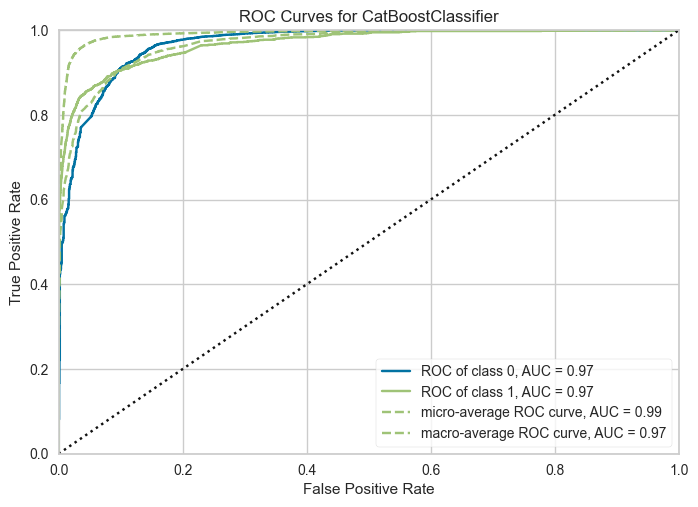

In [75]:
plot_model(cat_model, plot = 'auc')

In [17]:
def best_f1(model, X_test, y_test):
    X_pred_prob = model.predict_proba(X_test)[:, 1]
    # Вычисляем precision, recall и thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, X_pred_prob)
    
    # Вычисляем F1-score для каждого порога
    f1_scores = [2 * (p * r) / (p + r) for p, r in zip(precision, recall)]
    
    # Находим порог, который максимизирует F1-score
    best_id = np.argmax(f1_scores)
    best_threshold = thresholds[best_id]
    best_f1 = np.max(f1_scores)
    best_prec = precision[best_id]
    best_rec = recall[best_id]
    
    print(f"Лучший порог: {best_threshold}")
    print(f"Лучшая точность (precision): {best_prec}")
    print(f"Лучшая полнота (recall): {best_rec}")
    print(f"Лучший F1-score: {best_f1}")

best_f1(cat_model, X_test, y_test)

Лучший порог: 0.28995966717066607
Лучшая точность (precision): 0.8607142857142858
Лучшая полнота (recall): 0.7507788161993769
Лучший F1-score: 0.8019966722129783


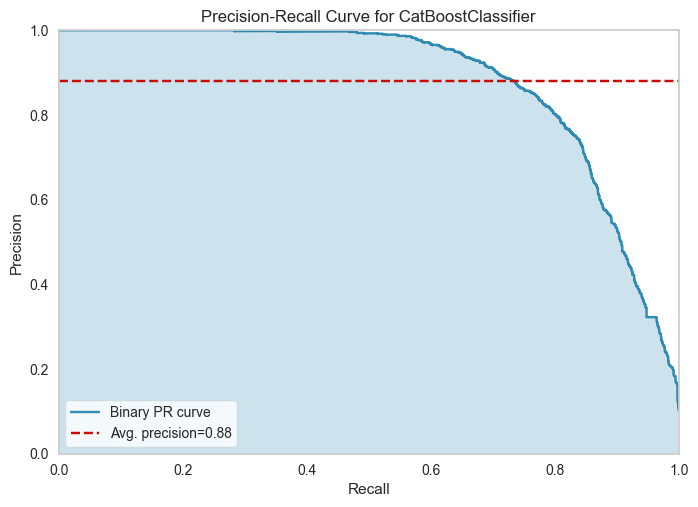

In [76]:
plot_model(cat_model, plot = 'pr')

In [66]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(metric='F1')
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Info] Number of positive: 16046, number of negative: 141844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.116229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409686
[LightGBM] [Info] Number of data points in the train set: 157890, number of used features: 1989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101628 -> initscore=-2.179268
[LightGBM] [Info] Start training from score -2.179268


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='F1', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=None, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [67]:
metrics(lgb_model, X_test, y_test)

Accuracy: 0.9583254164291596
AUC: 0.9637452932794267
Precision: 0.9239033124440466
Recall: 0.6429906542056075
F1: 0.7582659808963997


In [68]:
best_f1(lgb_model, X_test, y_test)

Лучший порог: 0.3124360931756268
Лучшая точность (precision): 0.8593984962406015
Лучшая полнота (recall): 0.7121495327102804
Лучший F1-score: 0.7788756388415672


In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [23]:
metrics(xgb_model, X_test, y_test)

Accuracy: 0.9600988029640889
AUC: 0.9602046006820902
Precision: 0.9526462395543176
Recall: 0.6392523364485981
F1: 0.7651006711409396


In [24]:
best_f1(xgb_model, X_test, y_test)

Лучший порог: 0.24063162505626678
Лучшая точность (precision): 0.8486562942008486
Лучшая полнота (recall): 0.7476635514018691
Лучший F1-score: 0.794965220271613


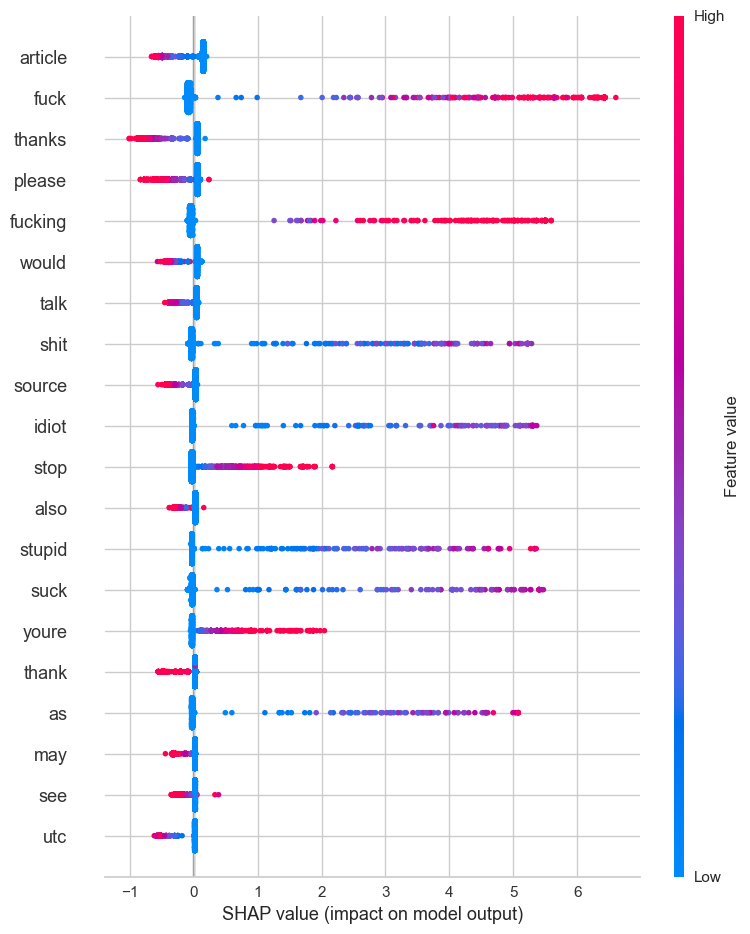

In [178]:
interpret_model(cat_model)

## Использование Bert

In [179]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [180]:
def get_distilbert_encoded(texts, tokenizer, batch_size=5):
    encoded = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding texts"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=32)
        encoded.append(inputs)

    return encoded

In [181]:
def get_distilbert_embeddings(encoded_texts, model):
    embeddings = []

    for encode_text in tqdm(encoded_texts, desc="Extracting embeddings"):
        with torch.no_grad():
            outputs = model(**encode_text)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        embeddings.append(batch_embeddings)

    return np.concatenate(embeddings, axis=0)

In [182]:
texts = df['text'].tolist()
labels = df['toxic'].values

encoded_text = get_distilbert_encoded(texts, tokenizer)

Encoding texts: 100%|███████████████████████████████████████████████████████████| 31578/31578 [03:54<00:00, 134.58it/s]


In [183]:
embeddings = get_distilbert_embeddings(encoded_text,model)
embeddings.shape

Extracting embeddings: 100%|███████████████████████████████████████████████████| 31578/31578 [3:20:20<00:00,  2.63it/s]


(157890, 768)

In [31]:
xgb_model_bert = XGBClassifier(use_label_encoder=False)
xgb_model_bert.fit(embeddings, labels, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [32]:
metrics(xgb_model_bert, embeddings, labels)

Accuracy: 0.9785040217873203
AUC: 0.9956423686750286
Precision: 0.9653523613358834
Recall: 0.8178362208650131
F1: 0.8854925775978407


In [33]:
best_f1(xgb_model_bert, embeddings, labels)

Лучший порог: 0.34808847308158875
Лучшая точность (precision): 0.9158672052511992
Лучшая полнота (recall): 0.9043375296023931
Лучший F1-score: 0.910065851364064


In [203]:
lgb_model_bert = LGBMClassifier(metric='F1')
lgb_model_bert.fit(embeddings, labels)

[LightGBM] [Info] Number of positive: 16046, number of negative: 141844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.019857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 157890, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101628 -> initscore=-2.179268
[LightGBM] [Info] Start training from score -2.179268


LGBMClassifier(metric='F1')

In [205]:
metrics(lgb_model_bert, embeddings, labels)

Accuracy: 0.950465513965419
AUC: 0.9661879980655289
Precision: 0.8842380640941792
Recall: 0.5898043126012713
F1: 0.7076152379528207


In [206]:
best_f1(lgb_model_bert, embeddings, labels)

Лучший порог: 0.3104496136165918
Лучшая точность (precision): 0.7695916479450244
Лучшая полнота (recall): 0.7258506792970211
Лучший F1-score: 0.747081462475946


In [197]:
cat_model_bert = CatBoostClassifier(eval_metric='F1')
cat_model_bert.fit(embeddings, labels)

Learning rate set to 0.089461
0:	learn: 0.3734778	total: 397ms	remaining: 6m 36s
1:	learn: 0.3980939	total: 767ms	remaining: 6m 22s
2:	learn: 0.4089873	total: 1.13s	remaining: 6m 16s
3:	learn: 0.4051629	total: 1.49s	remaining: 6m 11s
4:	learn: 0.4153193	total: 1.84s	remaining: 6m 6s
5:	learn: 0.4229524	total: 2.21s	remaining: 6m 5s
6:	learn: 0.4263433	total: 2.58s	remaining: 6m 6s
7:	learn: 0.4304831	total: 2.94s	remaining: 6m 4s
8:	learn: 0.4418813	total: 3.35s	remaining: 6m 8s
9:	learn: 0.4447371	total: 3.72s	remaining: 6m 8s
10:	learn: 0.4492822	total: 4.09s	remaining: 6m 7s
11:	learn: 0.4576919	total: 4.45s	remaining: 6m 6s
12:	learn: 0.4622040	total: 4.81s	remaining: 6m 5s
13:	learn: 0.4689336	total: 5.21s	remaining: 6m 7s
14:	learn: 0.4720927	total: 5.58s	remaining: 6m 6s
15:	learn: 0.4781751	total: 6.05s	remaining: 6m 12s
16:	learn: 0.4833668	total: 6.51s	remaining: 6m 16s
17:	learn: 0.4900740	total: 6.93s	remaining: 6m 18s
18:	learn: 0.4957729	total: 7.38s	remaining: 6m 21s
19:

In [198]:
metrics(cat_model_bert, embeddings, labels)

Accuracy: 0.9692254100956362
AUC: 0.982335286541169
Precision: 0.9635369188696444
Recall: 0.7246042627446092
F1: 0.8271618112616939


In [199]:
best_f1(cat_model_bert, embeddings, labels)

Лучший порог: 0.3665401712575383
Лучшая точность (precision): 0.9097373794268816
Лучшая полнота (recall): 0.8052474136856538
Лучший F1-score: 0.8543092333630864


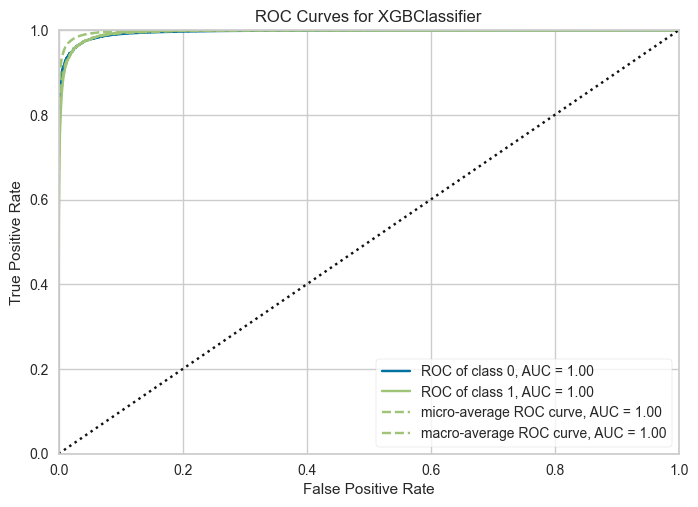

In [35]:
plot_model(xgb_model_bert, plot = 'auc')

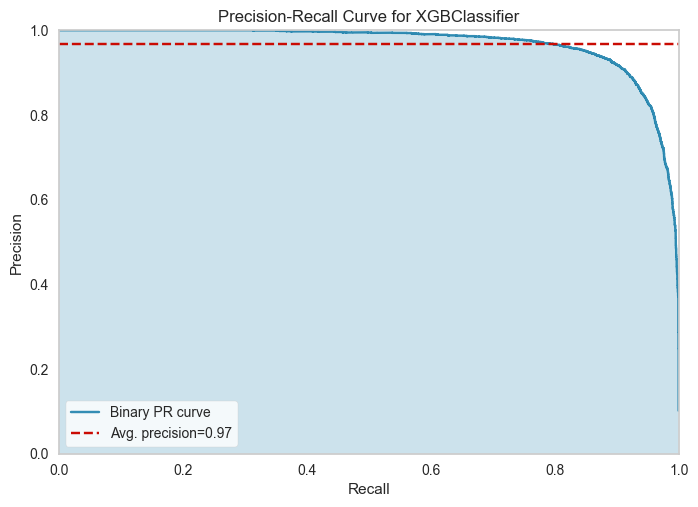

In [36]:
plot_model(xgb_model_bert, plot = 'pr')